get data from local database 

Matplotlib is building the font cache; this may take a moment.


successfully connected to database



/var/folders/h_/zfsm4hzn4gvfpzmqq5knct040000gn/T/ipykernel_19398/4150640917.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(drop_cols, 1)


# of parcels updated in 2020:  140
# of parcels updated in 2021:  36
total # of parcels in table:  40086


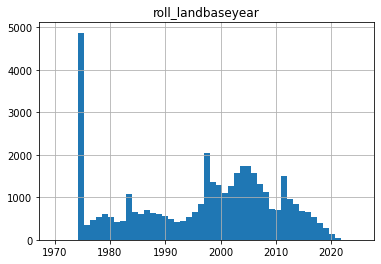

In [5]:
# %%time
import pandas as pd
import psycopg2
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# read data from local psql database into pd dataframe
try:
    conn = psycopg2.connect(database='parcelDatabase', user=os.getenv(
        "USER"), password=os.getenv("PASSWORD"))
    print("successfully connected to database")
except:
    print("I am unable to connect to the database")
df = pd.read_sql_query('select * from "svr_table_2"', con=conn)

# print(df.head())
print(df.iloc[0].situszip5)

# taking out irrelevant columns and cols related to building/development on land. Usecode is relevant col but dropping
# b/c we can't parse it rn
drop_cols = ['istaxableparcel', 'usecodedescchar1', 'usecodedescchar2', 'yearbuilt', 'effectiveyearbuilt', 'usecode']
df = df.drop(drop_cols, 1)

# convert columns of df to numeric
numeric_cols = ["roll_landbaseyear", "taxratearea", 
                "center_lat", "cluster", "situszip5",
                "center_lon", "roll_landvalue", "sqftmain"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)


# some basic visuals on distr of the land base year
df.hist(column="roll_landbaseyear", range=[1970, 2025], bins=51)

df_updated_2020 = df[df["roll_landbaseyear"] == 2020]
df_updated_2021 = df[df["roll_landbaseyear"] == 2021]

print("# of parcels updated in 2020: ", len(df_updated_2020))
print("# of parcels updated in 2021: ", len(df_updated_2021))
print("total # of parcels in table: ", len(df))


In [13]:
!pip list

Package           Version
----------------- -------
appnope           0.1.2
autopep8          1.5.7
backcall          0.2.0
cycler            0.11.0
debugpy           1.5.1
decorator         5.1.0
entrypoints       0.3
ipykernel         6.5.0
ipython           7.28.0
ipython-genutils  0.2.0
jedi              0.18.0
joblib            1.1.0
jupyter-client    7.0.6
jupyter-core      4.9.1
kiwisolver        1.3.2
matplotlib        3.4.3
matplotlib-inline 0.1.3
nest-asyncio      1.5.1
numpy             1.21.2
pandas            1.3.4
parso             0.8.2
pexpect           4.8.0
pickleshare       0.7.5
Pillow            8.4.0
pip               21.3.1
plotly            5.3.1
prompt-toolkit    3.0.21
psycopg2          2.9.1
ptyprocess        0.7.0
pybind11          2.7.1
pycodestyle       2.7.0
Pygments          2.10.0
pyparsing         3.0.4
python-dateutil   2.8.2
pytz              2021.3
pyzmq             22.3.0
scikit-learn      1.0.1
scipy             1.7.1
seaborn           0.11.2
setu

In [16]:
# !pip install sklearn_pandas
!pip3 install -U sklearn_pandas

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Attempting uninstall: sklearn-pandas
    Found existing installation: sklearn-pandas 1.5.0
    Uninstalling sklearn-pandas-1.5.0:
      Successfully uninstalled sklearn-pandas-1.5.0
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


based on this reference: https://www.kaggle.com/gauthampughazh/house-sales-price-prediction-svr/notebook

In [12]:
%%time
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from IPython.display import FileLink


ImportError: cannot import name 'CategoricalImputer' from 'sklearn_pandas' (/usr/local/lib/python3.9/site-packages/sklearn_pandas/__init__.py)

In [19]:
import sys
sys.executable

'/Users/yurynamgung/anaconda/bin/python'

In [ ]:

# split data into test and train
train_df, test_df = train_test_split(df, test_size=0.2)

# get correlation matrix
corr_matrix = train_df.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr_matrix, vmax=0.8, square=True)
plt.show()
